### <center>Chestnut Bur Detection and Segmentation using U-Net Learner in PyTorch</center>

In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, Subset, DataLoader
from torchvision import transforms as _transforms, tv_tensors
import torchvision.transforms.v2 as T
from cv2 import fillPoly
import json
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from pathlib import Path
from matplotlib.patches import Polygon
import shutil

from fastai.vision.all import Learner, Module, create_body, create_head, resnet34, params, accuracy, model_meta, get_image_files, RandomSplitter

##### Load the image and annotation data

In [2]:
# load annotations from json file here: "C:\Users\exx\Downloads\Route 9 Orchard 4.v1-test_dataset.coco-segmentation\train\_annotations.coco.json"
annos = json.load(open("C:/Users/exx/Downloads/Route 9 Orchard 4.v1-test_dataset.coco-segmentation/train/_annotations.coco.json"))

In [3]:
for key in annos.keys():
    print(annos[key])

{'year': '2024', 'version': '1', 'description': 'Exported from roboflow.com', 'contributor': '', 'url': 'https://public.roboflow.com/object-detection/undefined', 'date_created': '2024-08-13T19:46:53+00:00'}
[{'id': 1, 'url': 'https://creativecommons.org/licenses/by-nc-sa/4.0/', 'name': 'BY-NC-SA 4.0'}]
[{'id': 0, 'name': 'Chestnut-burr-CNsm', 'supercategory': 'none'}, {'id': 1, 'name': 'canopy', 'supercategory': 'Chestnut-burr-CNsm'}, {'id': 2, 'name': 'chestnut bur', 'supercategory': 'Chestnut-burr-CNsm'}]
[{'id': 0, 'license': 1, 'file_name': '107_png.rf.0890c9586fe43c53410d1f02f076ff4c.jpg', 'height': 1412, 'width': 1453, 'date_captured': '2024-08-13T19:46:53+00:00'}, {'id': 1, 'license': 1, 'file_name': '105_png.rf.4c53d3a84ad8e41bda83d406bd6327f8.jpg', 'height': 1366, 'width': 1319, 'date_captured': '2024-08-13T19:46:53+00:00'}, {'id': 2, 'license': 1, 'file_name': '101_png.rf.6ea0ba77d29d4b1cb1827ca8c3dcbb91.jpg', 'height': 1458, 'width': 1468, 'date_captured': '2024-08-13T19:46:

In [4]:
# convert the annos dict to a df, where each row is an image and the columns are the file name, the category name,
# the polygon coords, bbox, area, and iscrowd
import pandas as pd

annos_df = pd.DataFrame(annos["annotations"])
df = pd.DataFrame()
df["tree_id"] = annos_df["image_id"].apply(lambda x: annos["images"][x]["file_name"].split("_")[0])
df["file_name"] = annos_df["image_id"].apply(lambda x: annos["images"][x]["file_name"])
# file name is everything before first underscore in string plus ".png"
df["file_name"] = df["file_name"].apply(lambda x: x.split("_")[0] + ".png")
categories = [cat["name"] for cat in annos["categories"]]
df["category_name"] = annos_df["category_id"].apply(lambda x: categories[x])
df["bbox"] = annos_df["bbox"].apply(lambda x: torch.tensor(x))
df["area"] = annos_df["area"].apply(lambda x: torch.tensor(x))
df["segmentation"] = annos_df["segmentation"].apply(lambda x: torch.tensor(x))
df["iscrowd"] = annos_df["iscrowd"]

In [5]:
image_dir = "C:\\Users\\exx\\EasyIDP\\Route9_Orchard4\\Outputs\\Roboflow\\images"

image_names = df["file_name"].unique()

filtered_images_dir = "C:\\Users\\exx\\Deep Learning\\Chestnut_Bur_Instance_Segmentation\\filtered_images"
Path(filtered_images_dir).mkdir(exist_ok=True)
for image_name in image_names:
    shutil.copy(image_dir + "\\" + image_name, filtered_images_dir)

##### Plot Sample Image and Annotation Data

In [6]:
# modify plot_image_with_masks to plot multiple tree IDs as subplots
def plot_images_with_masks(image_dir:Path, tree_id_list, df:pd.DataFrame):
    fig, axs = plt.subplots(1, len(tree_id_list), figsize=(20, 10))
    for i, tree_id in enumerate(tree_id_list):
        image_name = df[df["tree_id"] == tree_id]["file_name"].values[0]
        image = Image.open(Path(image_dir) / image_name)

        # get the labels for the tree_id
        labels = df[df["tree_id"] == tree_id]["category_name"].values

        # encode categorical labels as integers
        labels = [categories.index(label) for label in labels]

        canopy_poly = df[(df["tree_id"] == tree_id) & (df["category_name"] == "canopy")]["segmentation"].values
        bur_poly = df[(df["tree_id"] == tree_id) & (df["category_name"] == "chestnut bur")]["segmentation"].values

        canopy_poly = [np.array(poly[0]).reshape(-1, 2).astype(np.int32) for poly in canopy_poly]
        bur_poly = [np.array(poly[0]).reshape(-1, 2).astype(np.int32) for poly in bur_poly]

        canopy_mask = np.zeros((image.height, image.width))
        bur_mask = np.zeros((image.height, image.width))

        canopy_mask = fillPoly(canopy_mask, canopy_poly, 1)
        bur_mask = fillPoly(bur_mask, bur_poly, 2)

        # stack the mask_image, canopy_mask, and bur_mask
        mask_image = np.stack((np.zeros((image.height, image.width)), canopy_mask, bur_mask), axis=-1)

        axs[i].imshow(image)
        axs[i].imshow(mask_image, alpha=0.7)
        axs[i].axis("off")
        axs[i].set_title(f'Tree ID: {tree_id}')

    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


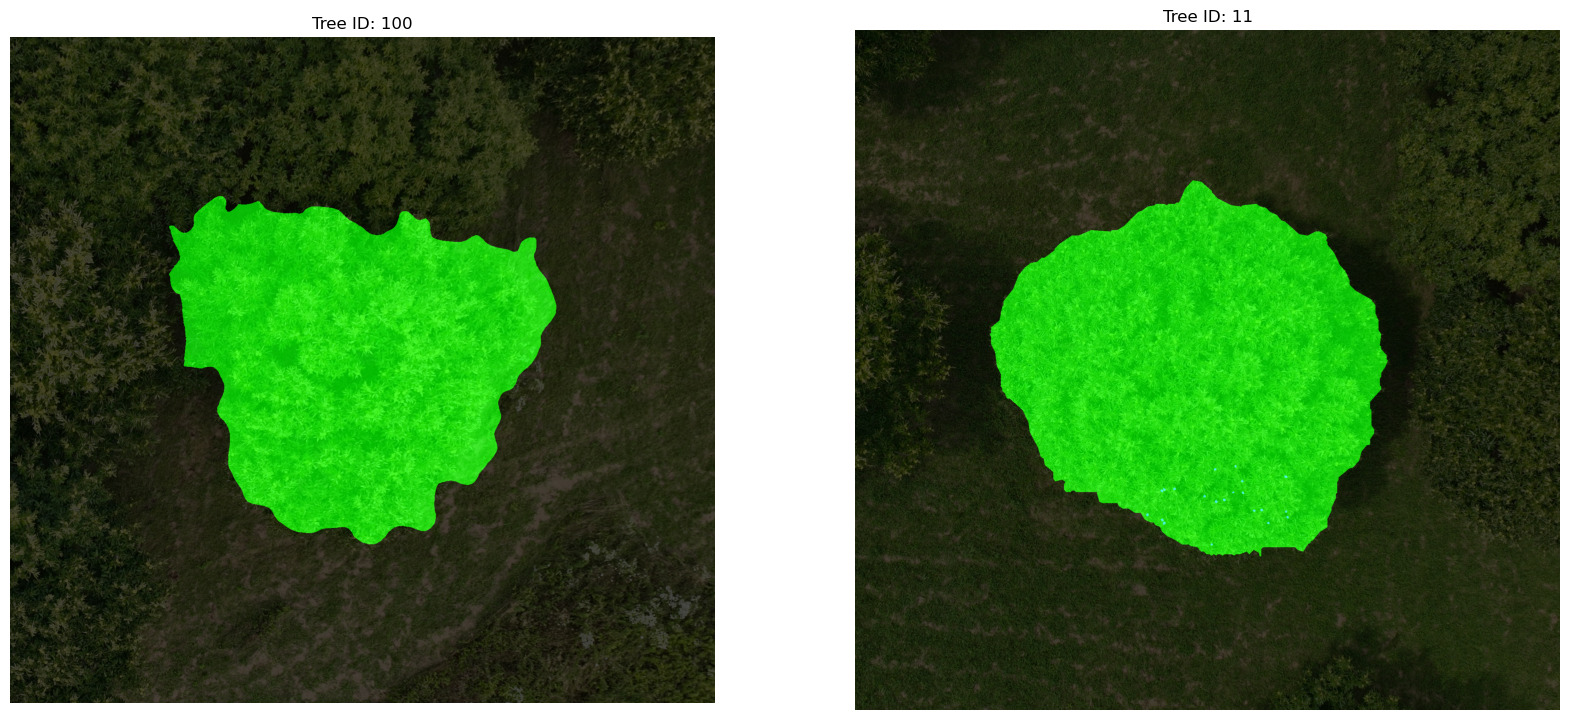

In [7]:
plot_images_with_masks(image_dir, ["100", "11"], df)

##### Pre-process and Transform Image and Annotation Data

##### Adapted from: https://github.com/usuyama/pytorch-unet

In [108]:
# Custom dataset loader (PyTorch) for loading images and annotation data
class ChestnutBurSegmentation(Dataset):
    """Custom Dataset for Chestnut Bur Segmentation in UAV Images"""

    def __init__(self, image_dir, df, transform=None):
        self.image_dir = image_dir
        self.df = df
        self.transform = transform
        self.unique_tree_ids = self.df["tree_id"].unique()

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        tree_id = self.unique_tree_ids[idx]

        row = self.df[self.df["tree_id"] == tree_id].iloc[0]

        image_file = Path(self.image_dir) / row["file_name"]

        image = tv_tensors.Image(Image.open(image_file))
        height, width = image.shape[-2:]

        canopy_poly = self.df[(self.df["tree_id"] == tree_id) & (self.df["category_name"] == "canopy")]["segmentation"].values
        bur_poly = self.df[(self.df["tree_id"] == tree_id) & (self.df["category_name"] == "chestnut bur")]["segmentation"].values

        canopy_poly = [np.array(poly[0]).reshape(-1, 2).astype(np.int32) for poly in canopy_poly]
        bur_poly = [np.array(poly[0]).reshape(-1, 2).astype(np.int32) for poly in bur_poly]

        canopy_mask = fillPoly(np.zeros((height, width)), canopy_poly, 1)
        bur_mask = fillPoly(np.zeros((height, width)), bur_poly, 2)

        # stack the mask_image, canopy_mask, and bur_mask
        mask_image = np.stack((np.zeros((height, width)), canopy_mask, bur_mask), axis=-1)
        mask_image = tv_tensors.Mask(mask_image, dtype=torch.float32).permute(2, 0, 1)

        # get the labels for the tree_id
        labels = self.df[self.df["tree_id"] == tree_id]["category_name"].values

        # encode categorical labels as integers
        labels = [categories.index(label) for label in labels]

        # get the bounding boxes for the tree_id
        bboxes = self.df[self.df["tree_id"] == tree_id]["bbox"].values
        # bboxes need to be in the format (x_min, y_min, x_max, y_max)
        bboxes = [torch.tensor([bbox[0], bbox[1], bbox[0] + bbox[2], bbox[1] + bbox[3]], dtype = torch.float32) for bbox in bboxes]
        bboxes = torch.stack([bbox for bbox in bboxes], dim=0) # (n_objects, 4)
        
        target = {}
        target["boxes"] = tv_tensors.BoundingBoxes(bboxes, format=tv_tensors.BoundingBoxFormat.XYXY, canvas_size=(height, width)) 
        target["labels"] = torch.as_tensor(labels, dtype = torch.int64) # (n_objects)
        target["image_id"] = torch.tensor(int(tree_id))

        if self.transform is not None:
            # normalize image using imagenet stats
            image = T.Compose([T.ToDtype(torch.float32, scale=True), T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])(image)
            image_and_mask = torch.cat([image, mask_image], dim=0) # combine image and mask for transformation
            image_and_mask, target = self.transform(image_and_mask, target)
            image = image_and_mask[:image.shape[0], :, :] # slice out the transformed image
            target["masks"] = image_and_mask[image.shape[0]:, :] # slice out the transformed mask
        else:
            image = image
            target["masks"] = mask_image

        return image, target

    def collate_fn(batch):
        return tuple(zip(*batch))

    def __len__(self):
        return len(self.unique_tree_ids)

In [109]:
# define transforms for the dataset
def get_transform(train):
    transforms = []
    if train:
        transforms.append(T.RandomZoomOut(fill = {tv_tensors.Image: (255, 20, 147), tv_tensors.Mask: (0,0,0)},
                                          p = 0.3,
                                          side_range = (1.0, 1.4)))
        # transforms.append(T.RandomIoUCrop())
        transforms.append(T.Resize((448, 448), interpolation=T.InterpolationMode.NEAREST, antialias = True)) # no maintain aspect ratio
        transforms.append(T.RandomHorizontalFlip(0.5))
    else:
        transforms.append(T.Resize((448, 448), interpolation=T.InterpolationMode.NEAREST, antialias = True)) # no maintain aspect ratio
    transforms.append(T.ClampBoundingBoxes())
    transforms.append(T.SanitizeBoundingBoxes())
    return T.Compose(transforms)

In [110]:
splits = RandomSplitter()(df["tree_id"].unique())

train_ds = ChestnutBurSegmentation(image_dir, df, get_transform(train = True))
valid_ds = ChestnutBurSegmentation(image_dir, df, get_transform(train = False))

train_ds = Subset(train_ds, splits[0])
valid_ds = Subset(valid_ds, splits[1])

train_dl = DataLoader(train_ds, batch_size = 8, shuffle = True, collate_fn = ChestnutBurSegmentation.collate_fn)
valid_dl = DataLoader(valid_ds, batch_size = 1, shuffle = False, collate_fn = ChestnutBurSegmentation.collate_fn)

In [111]:
images, targets = next(iter(train_dl))
images = [img for img in images]
targets = [{k: v for k, v in target.items()} for target in targets]

##### Plot transformed images, targets, masks to confirm data loads correctly

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


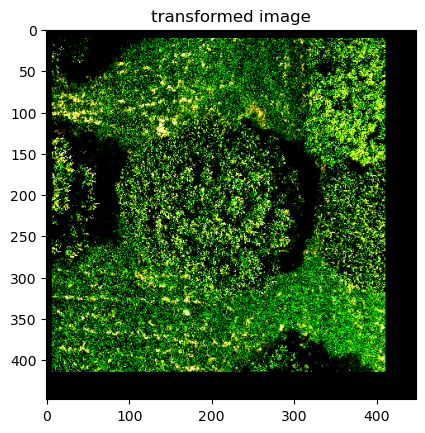

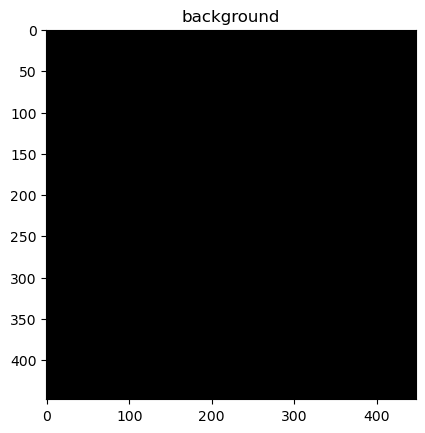

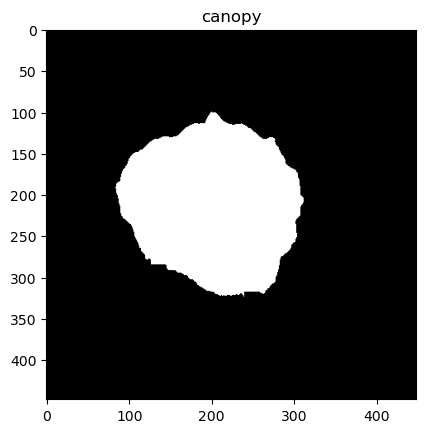

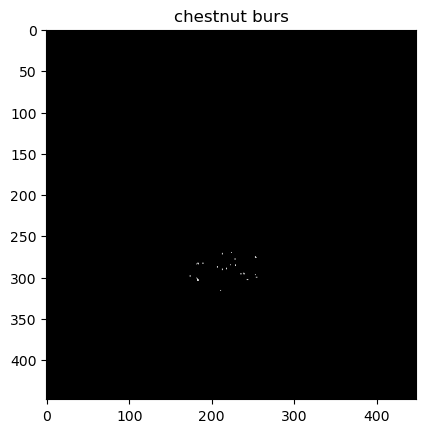

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


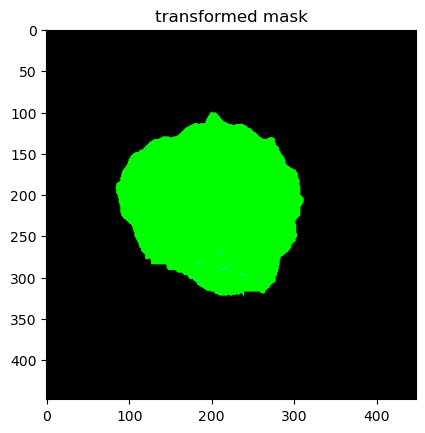

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


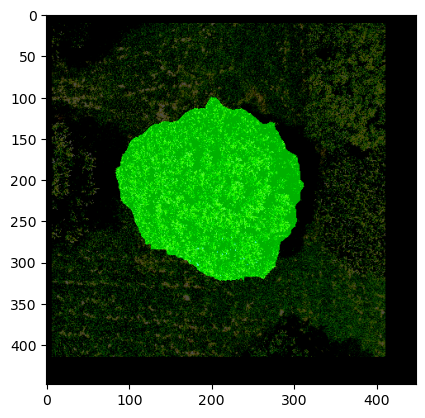

In [120]:
tree_ids = [target["image_id"].item() for target in targets]
tree_11_idx = tree_ids.index(11)
tree_11_idx

# plot the sample masks where target["image_id"] == 11
image = images[tree_ids.index(11)].permute(1, 2, 0)
mask = targets[tree_ids.index(11)]["masks"].permute(1, 2, 0)
mask_0 = mask[:, :, 0]
mask_1 = mask[:, :, 1]
mask_2 = mask[:, :, 2]


plt.imshow(image)
plt.title("transformed image")
plt.show()

plt.imshow(mask_0, cmap="gray")
plt.title("background")
plt.show()

plt.imshow(mask_1, cmap="gray")
plt.title("canopy")
plt.show()

plt.imshow(mask_2, cmap="gray")
plt.title("chestnut burs")
plt.show()

plt.imshow(mask, cmap="gray")
plt.title("transformed mask")
plt.show()

# plot mask on image
plt.imshow(image)
plt.imshow(mask, cmap='gray', alpha=0.7)

##### Build U-Net Model Architecture

In [70]:
class SiameseModel(Module):
    def __init__(self, encoder, head):
        self.encoder,self.head = encoder,head

    def forward(self, x1, x2):
        ftrs = torch.cat([self.encoder(x1), self.encoder(x2)], dim=1)
        return self.head(ftrs) 

In [71]:
encoder = create_body(resnet34(), cut=model_meta[resnet34]['cut'])
head = create_head(512*4, 2)
model = SiameseModel(encoder, head)
model

SiameseModel(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=

In [72]:
def loss_func(out, targ):
    return nn.CrossEntropyLoss()(out, targ.long())

In [73]:
def siamese_splitter(model):
    return [params(model.encoder), params(model.head)]

In [ ]:
learn = Learner(dls, model, loss_func = loss_func, splitter=siamese_splitter, metrics=accuracy)
learn.freeze() # freeze all layers but the last one (i.e., siaemese head)

In [ ]:
learn.fit_one_cycle(4, 3e-3)

In [ ]:
learn.unfreeze() # unfreeze all layers and continue training
learn.fit_one_cycle(4, slice(1e-6,1e-4))